# K-means кластеризація для сегментації користувачів, заснованої на RFM змінних

У цьому ДЗ вирішуватимемо задачу сегментації користувачів, виходячи з їх нещодавності та частоти покупок, а також сум витрат на них.

Імпорти розташуйте під цією клітиною.

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from scipy.stats import skew
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


Будемо використовувати набір даних із наступного джерела: https://archive.ics.uci.edu/ml/datasets/online+retail 

Attribute Information
Additional Information

InvoiceNo: Invoice number. 
Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.	

InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Numeric, Product price per unit in sterling.

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides. 

1.Завантажте набір даних із файлу. Виведіть перші 5 записів та розмір набору даних.

In [2]:
df = pd.read_excel("Online Retail.xlsx")
print(df.head(5))
print(df.shape)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
(541909, 8)


## Підготовка даних

2. Проведіть невеликий аналіз даних.
2.1.Виведіть результат методу describe() для числових колонок. Виведіть кількість унікальних значень у кожній категоріальній колонці.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])
numeric_description = numeric_columns.describe()
print("describe() для числових колонок:")
print(numeric_description)

describe() для числових колонок:
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


In [5]:
categorical_columns = df.select_dtypes(include=['object', 'datetime64[ns]'])
categorical_unique_counts = categorical_columns.nunique()
print("Унікальні значення для категоріальних колонок:")
print(categorical_unique_counts)

Унікальні значення для категоріальних колонок:
InvoiceNo      25900
StockCode       4070
Description     4223
InvoiceDate    23260
Country           38
dtype: int64


In [6]:
# рядок з мінімальним значенням по колонці quantity
min_row = df[df["Quantity"] == df["Quantity"].min()]
print(min_row)

       InvoiceNo StockCode                  Description  Quantity  \
540422   C581484     23843  PAPER CRAFT , LITTLE BIRDIE    -80995   

               InvoiceDate  UnitPrice  CustomerID         Country  
540422 2011-12-09 09:27:00       2.08     16446.0  United Kingdom  


In [7]:
# рядок з мінімальним значенням по колонці UnitPrice
min_row = df[df["UnitPrice"] == df["UnitPrice"].min()]
print(min_row)

       InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom  


2.1.1.Як можна пояснити те, що у змінних Quantity і UnitPrice мінімальне значення негативне?

так як це дані по транзакціях - а вони можуть бути відʼємними - вище я вивела рядок з мінімальним значенням по колонці Quantity - де видно, що InvoiceNo - починається із C - тобто відміна транзакції. 

для UnitPrice в колонці з описом бачимо, що це списання безнадійної заборгованості. Тому відʼємні значення вписуються в здоровий глузд.

2.1.2. Як ви вважаєте, чи варто залишати ці дані (з негативними значеннями Quantity і UnitPrice) у наборі даних, виходячи з задачі, яку ми вирішуємо? Аргументуйте свою відповідь.
Якщо ви вважаєте, що ці рядки треба видалити, видаліть їх.

є два можливі варіанти роботи :
1) виходячи з опису завдання - то нам потрібно сформувати кластери наших покупців = то було б файно видалити їх - адже нам потрібно бачити тільки тих клієнтів, які дійсно роблять покупки та приносять гроші, скасування ж та коригування на безнадійну заборгованість - 
2) або в окремий кластер виділяти , алк як і що з ним робити - неясно (що не факт що вийде) 
 
 
 тому delete them!

задачу сегментації користувачів, виходячи з їх нещодавності та частоти покупок, а також сум витрат на них.

In [8]:
df_cleaned = df[(df['Quantity'] >= 0) & (df['UnitPrice'] >= 0)]

2.2.Виведіть відсоток відсутніх значень у кожній із колонок.

In [9]:
missing_percentage = df_cleaned.isnull().mean() * 100
print("Відсоток відсутніх значень у кожній колонці:")
print(missing_percentage)

Відсоток відсутніх значень у кожній колонці:
InvoiceNo       0.000000
StockCode       0.000000
Description     0.111428
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     25.101311
Country         0.000000
dtype: float64


2.4. Видаліть рядки з відсутніми значеннями.

In [10]:
#  Видалення рядків з пропущеними значеннями у колонках "Description" та "CustomerID"
df_cleaned = df.dropna(subset=['Description', 'CustomerID'])

# Виведення оновленого DataFrame без рядків з пропущеними значеннями
print(df_cleaned)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      

2.5. Виведіть значення змінної Country, відсортувавши їх за відсотком присутності в даних.
Тобто вгорі має бути значення, яке найчастіше є у даних.

In [11]:
# Визначення відсотку присутності значень "Country"
country_counts = df_cleaned['Country'].value_counts(normalize=True) * 100

# Сортування за відсотком присутності
sorted_countries = country_counts.sort_values(ascending=False)

# Виведення значень "Country" з відсортованим відсотком присутності
print(sorted_countries)

United Kingdom          88.950886
Germany                  2.333904
France                   2.087118
EIRE                     1.839839
Spain                    0.622620
Netherlands              0.582800
Belgium                  0.508567
Switzerland              0.461373
Portugal                 0.363789
Australia                0.309467
Norway                   0.266943
Italy                    0.197380
Channel Islands          0.186319
Finland                  0.170833
Cyprus                   0.152890
Sweden                   0.113561
Austria                  0.098567
Denmark                  0.095618
Japan                    0.087998
Poland                   0.083819
USA                      0.071529
Israel                   0.061451
Unspecified              0.059976
Singapore                0.056289
Iceland                  0.044736
Canada                   0.037116
Greece                   0.035887
Malta                    0.031217
United Arab Emirates     0.016715
European Commu

2.6.У наборі даних є значення змінної Country, яке зустрічається найчастіше.
Відфільтруйте дані лише до тих записів, які мають значення змінної Country. Це спростить нам задачу, до того ж для інших значень Country обмаль даних.

In [12]:
# Знаходимо значення "Country", яке зустрічається найчастіше
most_common_country = df_cleaned['Country'].value_counts().idxmax()

# Відфільтровуємо дані лише до записів з найчастішим значенням "Country"
filtered_df = df_cleaned.loc[df_cleaned['Country'] == most_common_country]

# Виведення відфільтрованих даних
print(filtered_df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541889    581585     22466       FAIRY TALE COTTAGE NIGHT LIGHT        12   
541890    581586     22061  LARGE CAKE STAND  HANGING STRAWBERY         8   
541891    581586     23275     SET OF 3 HANGING OWLS OLLIE BEAK        24   
541892    581586     21217        RED RETROSPOT ROUND CAKE TINS        24   
541893    581586     20685                DOORMAT RED RETROSPOT        10   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      

2.7. Створіть стовпець Date із значень у стовпці InvoiceDate. Стовпець Date повинен містити дату у форматі рік-місяць-день, наприклад "2021-10-24".

In [13]:
filtered_df.loc[:, 'Date'] = filtered_df['InvoiceDate'].dt.strftime('%Y-%m-%d')

# Виведення оновленого DataFrame зі стовпцем "Date"
print(filtered_df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541889    581585     22466       FAIRY TALE COTTAGE NIGHT LIGHT        12   
541890    581586     22061  LARGE CAKE STAND  HANGING STRAWBERY         8   
541891    581586     23275     SET OF 3 HANGING OWLS OLLIE BEAK        24   
541892    581586     21217        RED RETROSPOT ROUND CAKE TINS        24   
541893    581586     20685                DOORMAT RED RETROSPOT        10   

               InvoiceDate  UnitPrice  CustomerID         Country        Da

/var/folders/r7/mpd7z_ms31j9b6hwvjlnymsh0000gn/T/ipykernel_7504/1226887273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'Date'] = filtered_df['InvoiceDate'].dt.strftime('%Y-%m-%d')


Отже, на даний момент у нас є всі необхідні дані для вирішення задачі:
- Customer ID
- Unit Price
- Quantity
- Invoice Date

## RFM

Давність-частота-грошовий вираз (Recency-Frequency-Monetary)
    
    
RFM-аналіз дозволяє сегментувати клієнтів за частотою та вартістю покупок та визначати тих клієнтів, які витрачають найбільше грошей.

* Давність - скільки часу пройшло з того часу, як клієнт щось купив у нас.
* Частота - як часто клієнт купує у нас.
* Грошовий вираз - загальна вартість покупок, здійснених покупцем.

Логічно припустити з опису вище, що **дані мають бути згруповані за клієнтами**. Інакше немає сенсу виводити Recency та Частоту.

3.1.Визначте останню дату транзакції у наборі даних. Ця дата нам необхідна, щоб визначати, як давно користувач робив покупку. Але дані історичні і якщо ми візьмемо для розрахунку recency фактичну сьогоднішню дату, розподіл recency буде зрушений у бік кількох сотень днів.
Щоб розподіл recency розпочинався з нуля, за дату "сьогодні" ми візьмемо дату останньої транзакції в наборі даних. Запишіть знайдену дату змінної NOW.

In [14]:
NOW = df_cleaned['InvoiceDate'].max()

NOW

Timestamp('2011-12-09 12:50:00')

### Recency

3.2.У змінну R_df запишіть recency dataframe, що складається з колонок CustomerID, Last_Purchase_Date та Recency,
де     
   - Last_Purchase_Date - це дата останньої покупки клієнта;
   - Recency - скільки днів минуло з дати останньої покупки клієнта до NOW.

In [15]:
# Обчислення останньої дати покупки для кожного клієнта
last_purchase_dates = df_cleaned.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase_dates.rename(columns={'InvoiceDate': 'Last_Purchase_Date'}, inplace=True)

# Обчислення Recency - різниці між останньою датою покупки та NOW
last_purchase_dates['Recency'] = (NOW - last_purchase_dates['Last_Purchase_Date']).dt.days

# Створення dataframe R_df з колонками CustomerID, Last_Purchase_Date та Recency
R_df = last_purchase_dates[['CustomerID', 'Last_Purchase_Date', 'Recency']]


R_df


,CustomerID,Last_Purchase_Date,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309
...,...,...,...
4367,18280.0,2011-03-07 09:52:00,277
4368,18281.0,2011-06-12 10:53:00,180
4369,18282.0,2011-12-02 11:43:00,7
4370,18283.0,2011-12-06 12:02:00,3


### Frequency - Monetary

3.3.Створіть Frequency - Monetary dataframe у змінній FM_df.  
Датафрейм повинен містити
- CustomerID - ідентифікатор клієнта
- Frequency - кількість покупок клієнта (кількість унікальних інвойсів)
- Monetary - скільки грошей у магазині витратив клієнт

In [16]:
# Frequency
frequency_df = df_cleaned.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_df.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)

# Monetary
monetary_df = df_cleaned.groupby('CustomerID')['UnitPrice'].sum().reset_index()
monetary_df.rename(columns={'UnitPrice': 'Monetary'}, inplace=True)

# Створення dataframe FM_df з колонками CustomerID, Frequency та Monetary
FM_df = pd.merge(frequency_df, monetary_df, on='CustomerID')

FM_df


,CustomerID,Frequency,Monetary
0,12346.0,2,2.08
1,12347.0,7,481.21
2,12348.0,4,178.71
3,12349.0,1,605.10
4,12350.0,1,65.30
...,...,...,...
4367,18280.0,1,47.65
4368,18281.0,1,39.36
4369,18282.0,3,62.68
4370,18283.0,16,1220.93


### RFM
3.4.Створіть RFM_df, який є об'єднанням R_df та FM_df за ідентифікатором клієнта.

In [17]:
RFM_df = pd.merge(R_df, FM_df, on='CustomerID')


RFM_df

,CustomerID,Last_Purchase_Date,Recency,Frequency,Monetary
0,12346.0,2011-01-18 10:17:00,325,2,2.08
1,12347.0,2011-12-07 15:52:00,1,7,481.21
2,12348.0,2011-09-25 13:13:00,74,4,178.71
3,12349.0,2011-11-21 09:51:00,18,1,605.10
4,12350.0,2011-02-02 16:01:00,309,1,65.30
...,...,...,...,...,...
4367,18280.0,2011-03-07 09:52:00,277,1,47.65
4368,18281.0,2011-06-12 10:53:00,180,1,39.36
4369,18282.0,2011-12-02 11:43:00,7,3,62.68
4370,18283.0,2011-12-06 12:02:00,3,16,1220.93


## K-means для RFM сегментації

K-means дає кращий результат за наступних умов:
- Розподіл даних не спотворений (тобто немає довгих хвостів)
- Дані стандартизовані (тобто середнє значення 0 та стандартне відхилення 1).

4.1.Побудуйте діаграми розподілу даних (наприклад, sns.distplot) для колонок Recency, Frequency і Monetary RFM_df.
Виведіть коефіцієнт асиметрії кожної з колонок.

Коефіцієнт асиметрії для Recency: 1.2492366479193797
Коефіцієнт асиметрії для Frequency: 11.408357746755158
Коефіцієнт асиметрії для Monetary: 22.367521219476927


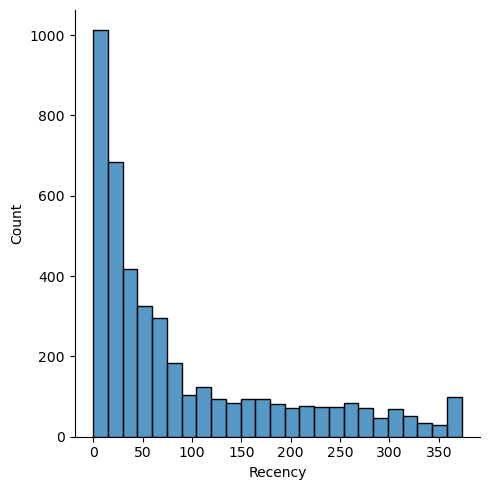

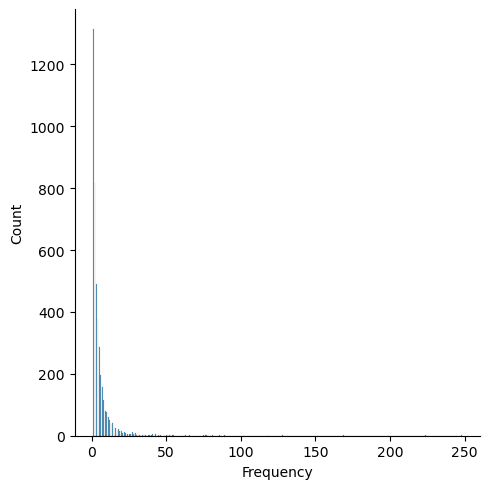

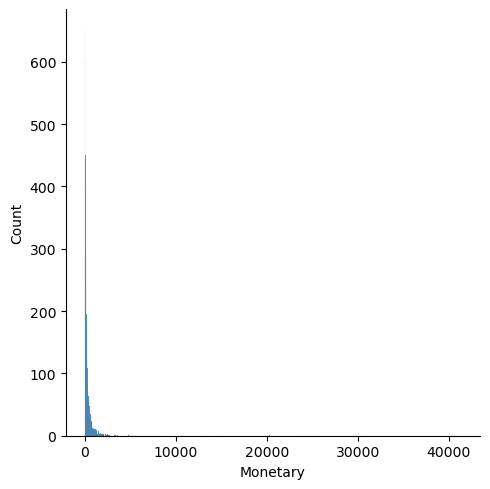

In [18]:
variables = ['Recency', 'Frequency', 'Monetary']

for var in variables:
    # Побудова діаграми розподілу
    sns.displot(RFM_df[var])
    
    # Виведення коефіцієнта асиметрії
    print('Коефіцієнт асиметрії для', var + ':', skew(RFM_df[var]))

Дані сильно перекручені, тому ми виконаємо над ними log перетворення, щоб зменшити асиметрію кожної змінної.

4.2.Над кожною зі змінних 'Recency', 'Frequency', 'Monetary' виконайте перетворення log(x+1).   
Додаємо константу, оскільки log перетворення вимагає, щоб усі значення були позитивними.
Відобразіть розподіл змінних після перетворення.

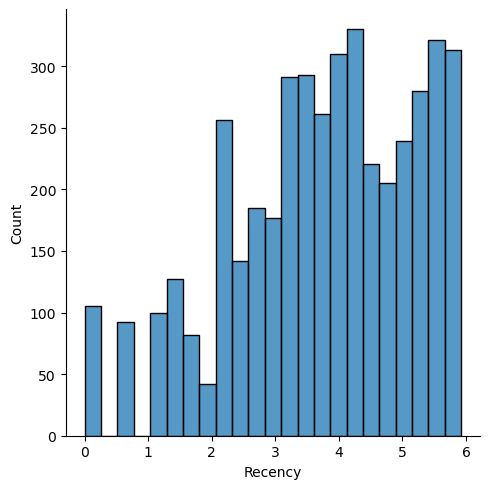

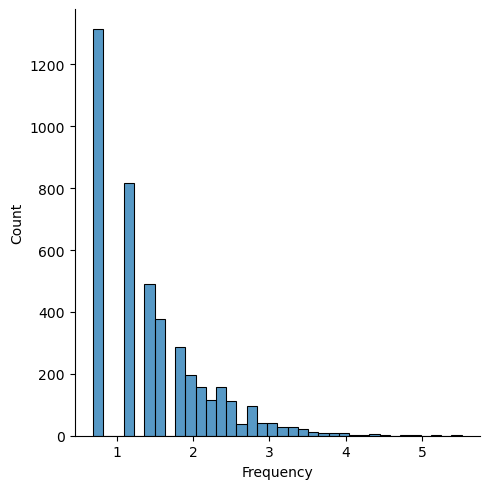

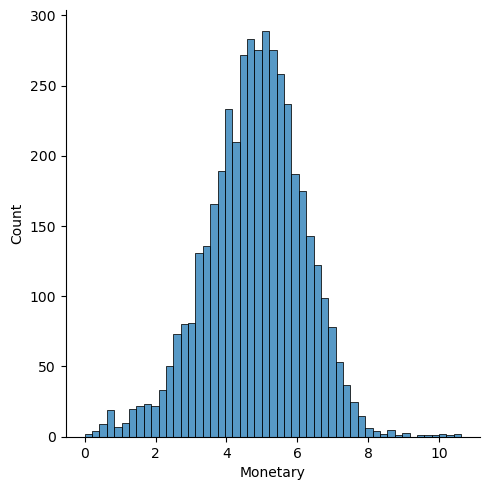

In [19]:
# Виконання перетворення log(x+1) над кожною змінною
RFM_df['Recency'] = np.log1p(RFM_df['Recency'])
RFM_df['Frequency'] = np.log1p(RFM_df['Frequency'])
RFM_df['Monetary'] = np.log1p(RFM_df['Monetary'])

# Побудова діаграм розподілу після перетворення
sns.displot(RFM_df['Recency'])
sns.displot(RFM_df['Frequency'])
sns.displot(RFM_df['Monetary'])

4.3.Бачимо, що в нас все одно залишилися хвости. Приберемо їх з використанням техніки **Winsorizing**.    

Прочитайте про неї тут: https://en.wikipedia.org/wiki/Winsorizing.    

Для використання техніки будемо використовувати бібліотеку [feature_engine](https://feature-engine.readthedocs.io/en/1.1.x/).    
Встановіть її.


Нам потрібний об'єкт Winsorizer. Імпортуйте його за допомогою
`from feature_engine.outliers import Winsorizer`.

У змінній windsoriser створіть екземпляр класу Winsorizer зі значеннями змінних 'tail='both'', 'fold=2', а в 'variables' передайте назви змінних, які ми хочемо перетворити.
Викличте метод fit().

In [20]:
windsoriser = Winsorizer(tail='both', fold=2, variables=['Recency', 'Frequency', 'Monetary'])
windsoriser.fit(RFM_df)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

Викликаємо трансформацію:

In [21]:
RFM_df_winsorized = windsoriser.transform(RFM_df)

### 4.4. Стандартизуйте наші RFM змінні 

так, щоб середнє було 0, а стандартне відхилення дорівнювало 1. Тут не треба ділити на трейн і тест, можемо працювати разом з повним набором даних.

In [22]:
RFM_df_winsorized_without_date = RFM_df_winsorized.drop('Last_Purchase_Date', axis=1)

# Видалення стовпця CustomerID перед стандартизацією
RFM_df_without_customerid = RFM_df_winsorized_without_date.drop('CustomerID', axis=1)

# Створення об'єкту StandardScaler та стандартизація
scaler = StandardScaler()
RFM_df_standardized = scaler.fit_transform(RFM_df_without_customerid)

# Повторне додавання стовпця CustomerID до стандартизованих даних
RFM_df_standardized_with_customerid = pd.DataFrame(RFM_df_standardized, columns=RFM_df_without_customerid.columns)
RFM_df_standardized_with_customerid['CustomerID'] = RFM_df_winsorized_without_date['CustomerID']


In [23]:
RFM_df_standardized_with_customerid.count()

Recency       4372
Frequency     4372
Monetary      4372
CustomerID    4372
dtype: int64

4.5. Знайдіть оптимальну кількість кластерів за допомогою Elbow Method.
Запустіть KMeans кластеризацію підготовлених стандартизованих RFM даних з параметром K від 1 до 10 включно.
Виконати це можна у циклі.
Відобразіть графічно отримані результати про значення сум внутрішньокластерних відстаней (у sklearn його називають inertia) для різних значень K.

/Users/vitamajstrenko/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/vitamajstrenko/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/vitamajstrenko/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/vitamajstrenko/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

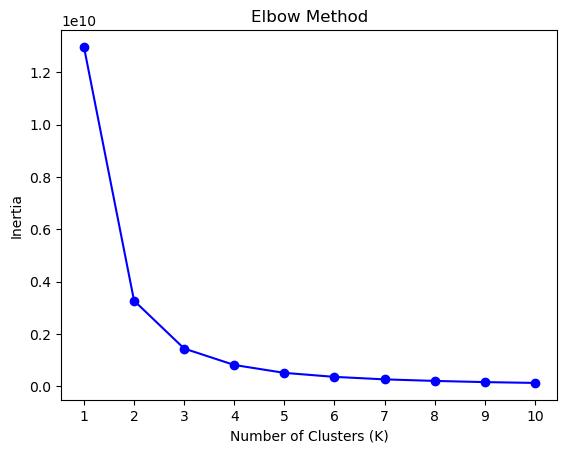

In [24]:
# Створення порожнього списку для збереження значень сум внутрішньокластерних відстаней
inertia = []

# Задання значень K від 1 до 10
k_values = range(1, 11)

# Виконання KMeans кластеризації для різних значень K
for k in k_values:
    # Створення об'єкту KMeans з поточним значенням K
    kmeans = KMeans(n_clusters=k, random_state=0)
    
    # Застосування KMeans на стандартизованих RFM даних
    kmeans.fit(RFM_df_standardized_with_customerid)
    
    # Додавання значення суми внутрішньокластерних відстаней до списку
    inertia.append(kmeans.inertia_)

# Візуалізація результатів
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.xticks(range(1, 11, 1))
plt.show()

Значення кластера, при якому зменшення значення inertia стає постійним, можна вибрати як правильне значення кластера для наших даних.
Спробуємо використовувати значення К від 3 до 5.

4.6.Створіть функцію, яка прийматиме набір даних для навчання (стандартизовані дані), значення К та набір даних з оригінальними (до стандартизації) значеннями (назвем його original_df_rfm).

Усередині функції необхідно
1. Навчити на стандартизованих даних Kmeans з кількістю кластерів К, що є аргументом функції.
2. Отримати ідентифікатори кластерів (лейбли).
3. Створити новий датафрейм як копію original_df_rfm.
4. До набору даних, отриманого в п.3, додайте колонку зі значенням кластера для даного рядка.
5. Виконайте зменшення розмірності за допомогою TSNE (можете спробувати замість TSNE використовувати PCA, і візуально порівняти результати).
6. Відобразити результати кластеризації.

Пункти 5 та 6 вже реалізовані за вас.
Запустіть функцію для значень K = {3,4,5}.
**Наша мета** - за допомогою візуалізацій зрозуміти, яка кількість кластерів оптимальна.

/Users/vitamajstrenko/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


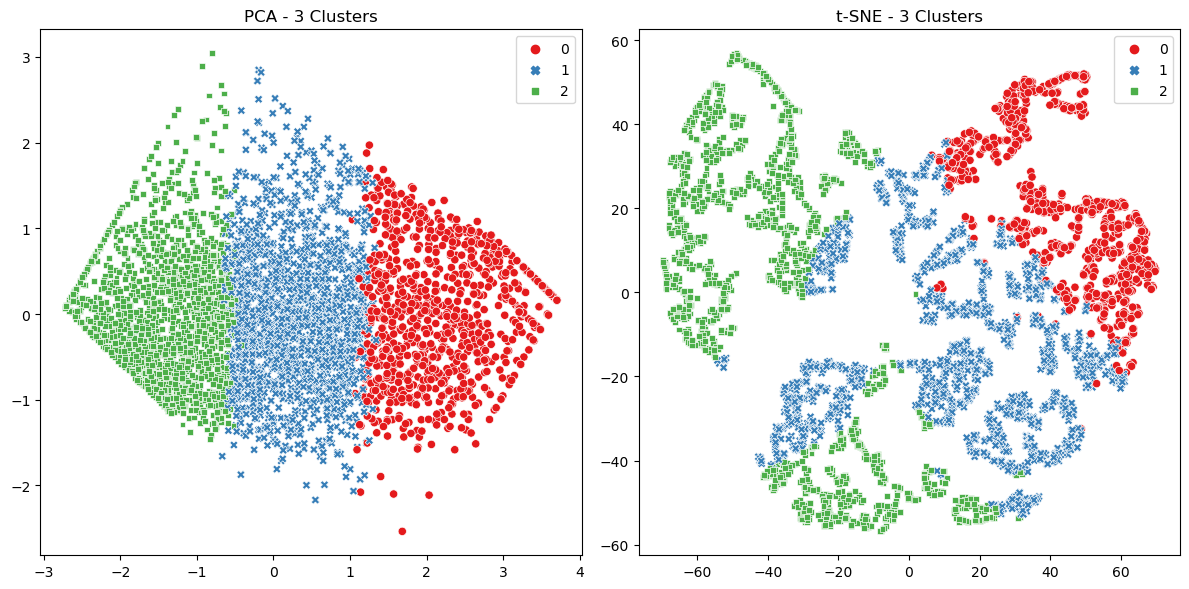

/Users/vitamajstrenko/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


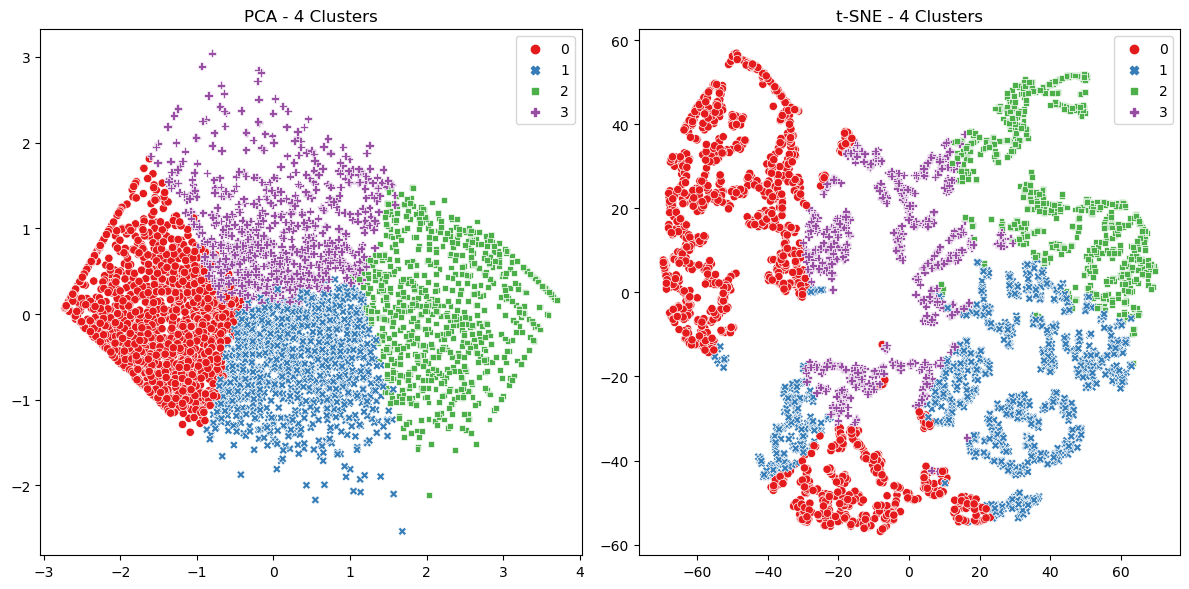

/Users/vitamajstrenko/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


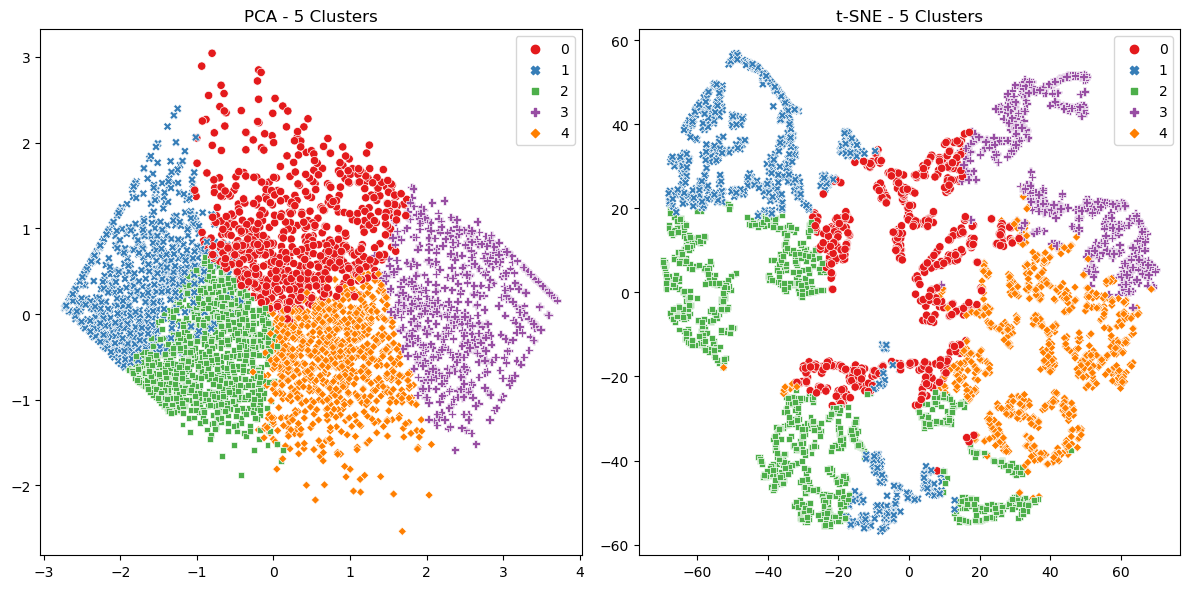

In [25]:
def fit_visualize_kmeans(RFM_df_standardized, clusters_number, original_df_rfm):
    # Навчання KMeans зі стандартизованими даними
    kmeans = KMeans(n_clusters=clusters_number)
    kmeans.fit(RFM_df_standardized)
    
    # Отримання ідентифікаторів кластерів (лейбли)
    cluster_labels = kmeans.labels_
        
    # Створення копії original_df_rfm з додатковою колонкою для лейблів кластерів
    df_new = original_df_rfm.copy()
    df_new['Cluster'] = cluster_labels
    
    # Зменшення розмірності за допомогою PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(RFM_df_standardized)
    
    # Зменшення розмірності за допомогою t-SNE
    tsne = TSNE(n_components=2, random_state=1)
    tsne_result = tsne.fit_transform(RFM_df_standardized)
    
    # Візуалізація результатів кластеризації
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Візуалізація PCA
    axes[0].set_title('PCA - {} Clusters'.format(clusters_number))
    params_pca = dict(
        x=pca_result[:, 0],
        y=pca_result[:, 1],
        hue=cluster_labels,
        style=cluster_labels,
        palette="Set1"
    )
    sns.scatterplot(ax=axes[0], **params_pca)
    
    # Візуалізація t-SNE
    axes[1].set_title('t-SNE - {} Clusters'.format(clusters_number))
    params_tsne = dict(
        x=tsne_result[:, 0],
        y=tsne_result[:, 1],
        hue=cluster_labels,
        style=cluster_labels,
        palette="Set1"
    )
    sns.scatterplot(ax=axes[1], **params_tsne)
    
    plt.tight_layout()
    plt.show()
    
    return df_new

# Виклик функції для K = {3, 4, 5}
K_values = [3, 4, 5]
for K in K_values:
    df_result = fit_visualize_kmeans(RFM_df_standardized, K, RFM_df_winsorized_without_date)



Проаналізуйте отримані графіки. При якій кількості кластерів на вашій основі з візуалізацій найкраще поділяються дані на кластери?

pca  виглядає краще ніж TSNE стандартизація... 

4 та 5 наче непогано виглядають, бо 3 замало.

4.7.Збудуємо додатково [Snake plots](https://www.marketingprofs.com/tutorials/snakeplot.asp), які часто використовують у маркетингових аналізах. 

Прочитайте про цей графік та давайте напишемо функцію для її реалізації.
У функції має відбуватися таке:
1. Створюємо датафрейм normalised_df_rfm, який містить оригінальні CustomerID, стандартизовані значення Recency, Frequency, Monetary та номер кластера.
2. Візуалізуємо датафрейм. Ця частина вже реалізована.  

Визначте відповідні аргументи функції самостійно. Вона має запускатися для різних результатів кластеризації.
Функція snake_plot може приймати декілька параметрів.

In [26]:
def snake_plot(RFM_df_standardized_with_customerid, num_clusters):
    # Створюємо датафрейм normalised_df_rfm
    normalised_df_rfm = pd.DataFrame({
        'CustomerID': RFM_df_standardized_with_customerid['CustomerID'],
        'Recency': RFM_df_standardized_with_customerid['Recency'],
        'Frequency': RFM_df_standardized_with_customerid['Frequency'],
        'Monetary': RFM_df_standardized_with_customerid['Monetary']
    })

    # Виконуємо кластеризацію
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(normalised_df_rfm[['Recency', 'Frequency', 'Monetary']])
    cluster_labels = kmeans.labels_

    normalised_df_rfm['Cluster'] = cluster_labels

    # "Розправляємо" дані в довгий формат
    df_melt = pd.melt(normalised_df_rfm.reset_index(),
                      id_vars=['CustomerID', 'Cluster'],
                      value_vars=['Recency', 'Frequency', 'Monetary'],
                      var_name='Metric',
                      value_name='Value')

    # Візуалізуємо графік
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')



/Users/vitamajstrenko/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/vitamajstrenko/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/vitamajstrenko/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


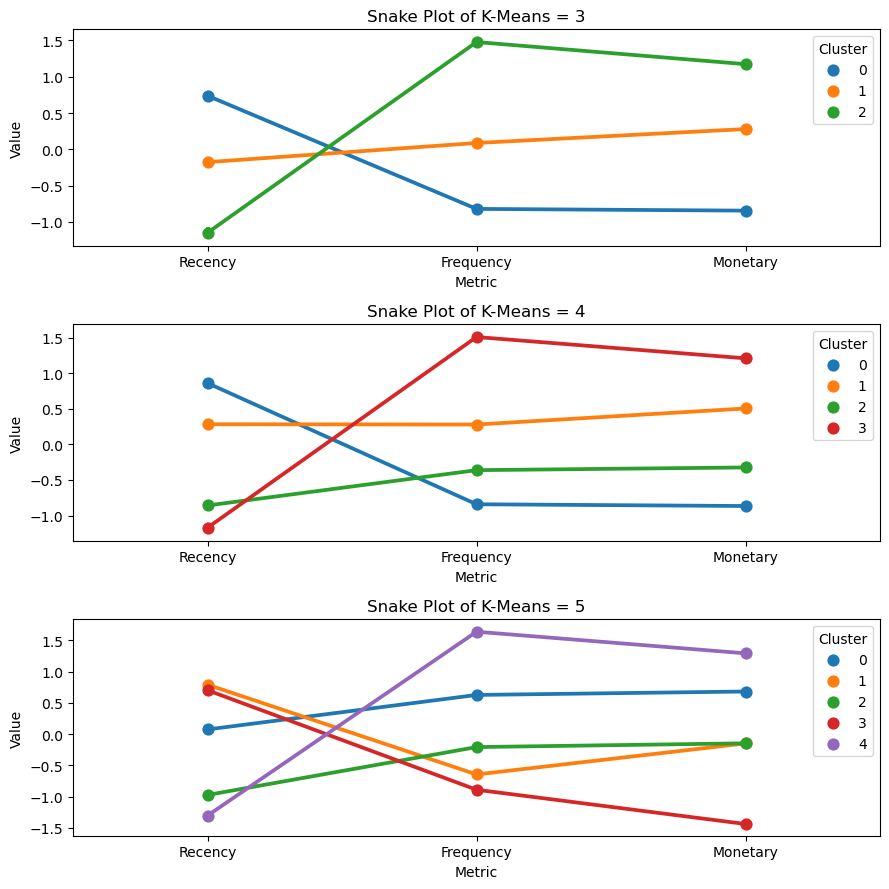

In [27]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_df_standardized_with_customerid, num_clusters=3)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_df_standardized_with_customerid, num_clusters=4)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_df_standardized_with_customerid, num_clusters=5)

plt.tight_layout()
plt.show()


Зі згладжених графіків і графіків-змій видно, що значення кластера, що дорівнює 4, добре сегментує наших клієнтів.
Ми також могли б піти на більшу кількість кластерів, що повністю залежить від того, як компанія хоче сегментувати своїх клієнтів. Але зазвичай 4 кластери – це зручно.

4.8.Інтерпретуємо результати кластеризації.
З результатів кластеризації з кількістю кластерів 4 (і оригінальними значеннями RFM змінних) сформуйте агрегат , який містить середнє значення по кожній із трьох колонок та кількість клієнтів у кластері.
Виведіть цей агрегат.

In [28]:
# Виконуємо кластеризацію з кількістю кластерів 4
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(RFM_df[['Recency', 'Frequency', 'Monetary']])
cluster_labels = kmeans.labels_

# Додаємо мітки кластерів до оригінального датафрейму
RFM_df['Cluster'] = cluster_labels

# Створюємо агрегат з середніми значеннями та кількістю клієнтів в кожному кластері
aggregate_df = RFM_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Customer Count'})

# Виводимо агрегат
print(aggregate_df)


          Recency  Frequency  Monetary  Customer Count
Cluster                                               
0        5.118625   0.891787  3.637840            1411
1        1.696352   2.421480  6.331567             823
2        2.817160   1.128797  4.059189             793
3        4.063190   1.607398  5.572351            1345


/Users/vitamajstrenko/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Зробіть висновки про отримані результати. Як би ви назвали кожний кластер? Які з них містять користувачів, що платять, а які - тих, хто потенційно піде у відтік?

Кластер 0 (1411 клієнтів): Цей кластер має високий середній показник Recency (5.12), що означає, що клієнти в цьому кластері давно не здійснювали покупки. Також вони мають низький показник Frequency (0.89) та Monetary (3.64), що свідчить про низьку активність та невеликі суми витрат. Цей кластер можна назвати "Недавні неактивні клієнти" і віднести до групи потенційно підлягаючих відтоку, оскільки вони не виявляють активність у покупках протягом тривалого часу.

Кластер 1 (823 клієнти): У цьому кластері клієнти мають низький показник Recency (1.70), що свідчить про недавні покупки. Вони також мають високі значення Frequency (2.42) та Monetary (6.33), що означає, що вони здійснюють часті покупки та витрачають великі суми грошей у магазині. Цей кластер можна назвати "Активні та лояльні клієнти" і вважати його цільовою аудиторією, яку необхідно утримувати та надавати їм належну увагу для подальшої збереженості.

Кластер 2 (793 клієнти): В цьому кластері клієнти також мають низький показник Recency (2.82), що свідчить про недавні покупки. Але їх значення Frequency (1.13) та Monetary (4.06) нижчі, ніж у кластері 1. Цей кластер можна назвати "Середньоактивні клієнти" і вони можуть потребувати додаткових заохочень чи стимулів для збільшення частоти покупок та витрат.

Кластер 3 (1345 клієнти): В цьому кластері клієнти мають середній показник Recency (4.06), що означає, що вони давно не здійснювали покупки. Але значення Frequency (1.61) та Monetary (5.57) вищі, ніж у кластері 0, що свідчить про більшу активність та витрати. Цей кластер можна назвати "Раніше активні клієнти" і вважати їх групою, яку можна знову залучити та зберегти якщо вжити відповідні заходи для повернення їх активності.

Отже, кластер 0 та кластер 3 можуть містити користувачів, які потенційно підлягають відтоку, оскільки вони давно не здійснювали покупок. Кластер 1 є групою активних та лояльних клієнтів, а кластер 2 - середньоактивними клієнтами, які можуть бути стимульовані для збільшення активності.